In [1]:
from imports import *
import george, batman, csv
from PyAstronomy.pyasl import MMSCETSTable
%matplotlib inline

In [2]:
main_directory = 'BIOPHYS_3D03_Assignment2'

def main():
    # loop over students
    macids =  np.sort(np.genfromtxt('mac_ids.csv', dtype='|S50').astype(str))
    macids = np.sort(['test'])
    
    for i,m in enumerate(macids):
        # create directory
        if not os.path.exists(main_directory): os.mkdir(main_directory)
        folder = '%s/%s'%(main_directory, m)
        if not os.path.exists(folder): os.mkdir(folder)
            
        # sample stellar parameters
        params1, params2, params3 = sample_three_stars()
            
        # create light curves
#         synthesize_system1(folder, params1)
        synthesize_system2(folder, params2)
#         synthesize_system3(folder, params3)
        
    return None

In [3]:
def compute_RHill(a, Mp, Ms):
    return a*(3.0404326480240676e-06/3 * Mp/Msun)**(1/3)

In [10]:
def create_LC(params_pl, Ntrmin, Ntrmax, pltt=False):
    t = np.arange(0, params_pl['P'][-1]*np.random.uniform(Ntrmin,Ntrmax)*np.random.normal(1,.01), 
                  np.round(params_pl['D'][-1]*60)/60/24/np.random.uniform(6,10))
    t += np.random.uniform(-np.diff(t)[0]/2, np.diff(t)[0]/2, t.size)
    t = np.sort(t)
    
    model_full = np.zeros_like(t)
    intransit = np.zeros(t.size).astype(bool)
    for i in range(len(params_pl['P'])):
        args = params_pl['P'][i], params_pl['T0'][i], params_pl['rpRs'][i], params_pl['aRs'][i], 90, .2, .4
        phase, model = rvs.transit_model(t, *args)
        intransit[abs(phase*params_pl['P'][i]*24) < 2*params_pl['D'][i]] = True
        
        model -= 1
        model *= abs(params_pl['rpRs'][i]**2 / np.nanmin(model))

        model_full += model
    
    model_full += 1
    
    # clean time series
    #intransit = model_full < 1 
    outtransit = np.where(np.invert(intransit))[0]
    np.random.shuffle(outtransit)
    mask = np.sort(np.append(np.where(intransit)[0], outtransit[:20000]))
    
    t = t[mask]
    phase = phase[mask]
    model_full = model_full[mask]
    
    # add activity
    activity = add_activity(t)
    model_full += activity
    
    # noise properties
    sig = (1-np.nanmin(model_full)) / params_pl['SNR']
    flux = model_full + np.random.normal(0, sig, t.size)
    err = np.repeat(sig, t.size)
        
    if pltt:
        plot_LC((t, phase, model_full, flux, err))
        plot_phasedLC((t, phase, model_full, flux, err), params_pl)
    
    return t, phase, model_full, flux, err



def add_activity(t):
    t_downsample = np.sort(np.append([t.min(),t.max()], np.unique(np.random.choice(t, 1000))))
    Prot = np.random.uniform(1.5, 5)
    
    kernel = george.kernels.ExpSquaredKernel(200) + george.kernels.ExpSine2Kernel(.5, Prot)
    gp = george.GP(kernel, mean=0)
    gp.compute(t_downsample)
    fint = interp1d(t_downsample, gp.sample(t_downsample))
    return fint(t)


def plot_LC(timeseries):
    t, phase, model_full, flux, err = timeseries
    plt.figure()
    plt.errorbar(t, flux, err, fmt='k.')
#     plt.plot(t, model_full, zorder=3)
    return None


def plot_phasedLC(timeseries, params_pl):
    t, phase, model_full, flux, err = timeseries
    phase *= params_pl['P'][-1]*24
    
    plt.figure()
    plt.errorbar(phase, flux, err, fmt='k.')
    s = np.argsort(phase)
    plt.plot(phase[s], model_full[s], zorder=3)
    plt.xlim(-2*params_pl['D'][-1], 2*params_pl['D'][-1])
    
    return None


def save_lc(folder, lc_index, timeseries):
    t, phase, model_full, flux, err = timeseries
    df = pd.DataFrame(np.array([t,flux,err]).T, 
                      columns=['Time [days]','Normalized Flux','Normalized Flux Errors'])
    df.to_csv('%s/lightcurve%i.csv'%(folder,lc_index), index=False)

In [11]:
def sample_three_stars():
    '''Sample three different host stars.'''
    # star table
    Mamajek_table = MMSCETSTable().getTable()
    MRint = interp1d(Mamajek_table['Msun'], Mamajek_table['R_Rsun'])
    MTint = interp1d(Mamajek_table['Msun'], Mamajek_table['Teff'])
    
    # low mass star
    Ms = np.random.uniform(.08, .5)
    params1 = [Ms, float(MRint(Ms)), float(MTint(Ms))]
    
    # Sun-like star
    Ms = np.random.uniform(.8, 1.2)
    params2 = [Ms, float(MRint(Ms)), float(MTint(Ms))]
    
    # high mass star
    Ms = np.random.uniform(3, 10)
    params3 = [Ms, float(MRint(Ms)), float(MTint(Ms))]
    
    # randomize the order
    p = [params1, params2, params3]
    np.random.shuffle(p)
    
    return p 
    
    
def synthesize_system1(folder, params_st):
    '''Sample a temperate terrestrial planet.'''
    # planet radius 
    params_pl = {}
    params_pl['Rp'] = np.random.uniform(.8,1.6,1)
    params_pl['F'] = 10**(np.random.uniform(np.log10(.5),np.log10(2),1))
    params_pl['A'] = np.random.uniform(.2,.8,1)
    
    # derive stuff
    Ms, Rs, Teff = params_st
    Ls = Rs**2 * (Teff/5780)**4
    params_pl['a'] = np.sqrt(Ls / params_pl['F'])
    params_pl['Teq'] = rvs.Teq(Teff, Rs, A=params_pl['A'], sma=params_pl['a'])
    params_pl['P'] = rvs.period_sma(params_pl['a'], Ms, 0)
    params_pl['rpRs'] = 0.009170524802300503 * params_pl['Rp'] / Rs
    params_pl['aRs'] = rvs.aRs(params_pl['P'], Ms, Rs)
    params_pl['D'] = 24*rvs.transit_width_aRs(params_pl['P'], params_pl['aRs'], params_pl['rpRs']**2, 0).astype(float)
    
    # create transit light curve
    params_pl['T0'] = np.random.uniform(0, params_pl['P']*.4)
    params_pl['SNR'] = np.random.uniform(3.9,5)
    
    # save star stuff
    params_st = {}
    params_st['Ms'], params_st['Rs'], params_st['Ls'], params_st['Teff'] = Ms, Rs, Ls, Teff
    
    # create LC
    timeseries = create_LC(params_pl, 3.5, 7, pltt=True)
    
    # save LC
    save_lc(folder, 1, timeseries)
    
    return params_st, params_pl
    
    
    
def synthesize_system2(folder, params_st):
    '''Sample a cold giant planet.'''
    # planet radius 
    params_pl = {}
    params_pl['Rp'] = 11.2*np.random.uniform(.7,1.3,1)
    params_pl['F'] = 10**(np.random.uniform(-2,-1,1))
    params_pl['A'] = np.random.uniform(.2,.8,1)
    
    # derive stuff
    Ms, Rs, Teff = params_st
    Ls = Rs**2 * (Teff/5780)**4
    params_pl['a'] = np.sqrt(Ls / params_pl['F'])
    params_pl['Teq'] = rvs.Teq(Teff, Rs, A=params_pl['A'], sma=params_pl['a'])
    params_pl['P'] = rvs.period_sma(params_pl['a'], Ms, 0)
    params_pl['rpRs'] = 0.009170524802300503 * params_pl['Rp'] / Rs
    params_pl['aRs'] = rvs.aRs(params_pl['P'], Ms, Rs)
    params_pl['D'] = 24*rvs.transit_width_aRs(params_pl['P'], params_pl['aRs'], params_pl['rpRs']**2, 0).astype(float)
    
    # create transit light curve
    params_pl['T0'] = np.random.uniform(0, params_pl['P']*.9)
    params_pl['SNR'] = np.random.uniform(9,14)
    
    # save star stuff
    params_st = {}
    params_st['Ms'], params_st['Rs'], params_st['Ls'], params_st['Teff'] = Ms, Rs, Ls, Teff
    
    # create LC
    timeseries = create_LC(params_pl, 1.8, 2, pltt=True)
    
    # save LC
    save_lc(folder, 2, timeseries)
        
    return params_st, params_pl



def synthesize_system3(folder, params_st):
    '''Sample multiple sub-Neptunes.'''
    # planet radius 
    params_pl = {}
    params_pl['Rp'] = np.random.uniform(2.2,4.5,2)
    params_pl['P'] = np.append(np.random.uniform(1,5), np.random.uniform(10,15))
    params_pl['A'] = np.random.uniform(.2,.8,2)
    
    # derive stuff
    Ms, Rs, Teff = params_st
    Ls = Rs**2 * (Teff/5780)**4
    params_pl['a'] = rvs.semimajoraxis(params_pl['P'], Ms, 0)
    params_pl['F'] = Ls/params_pl['a']**2
    params_pl['Teq'] = np.array([rvs.Teq(Teff, Rs, A=params_pl['A'][i], sma=params_pl['a'][i]) 
                                 for i in range(len(params_pl['P']))]) 
    params_pl['rpRs'] = 0.009170524802300503 * params_pl['Rp'] / Rs
    params_pl['aRs'] = rvs.aRs(params_pl['P'], Ms, Rs)
    params_pl['D'] = 24*rvs.transit_width_aRs(params_pl['P'], params_pl['aRs'], params_pl['rpRs']**2, 0).astype(float)
    
    # create transit light curve
    params_pl['T0'] = np.random.uniform(0, params_pl['P'][1]*.7, 2)
    params_pl['SNR'] = np.random.uniform(10,15)
    
    # save star stuff
    params_st = {}
    params_st['Ms'], params_st['Rs'], params_st['Ls'], params_st['Teff'] = Ms, Rs, Ls, Teff
    
    # create LC
    timeseries = create_LC(params_pl, 2.8, 5, pltt=True)
    
    # save LC
    save_lc(folder, 3, timeseries)
        
    return params_st, params_pl

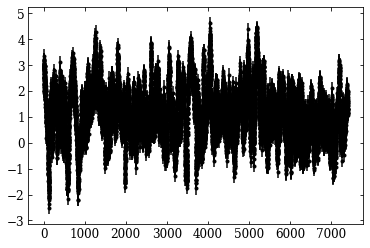

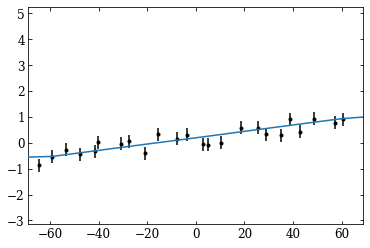

In [14]:
# main()
# sample_three_stars()
# params_st, params_pl = synthesize_system1(0, sample_three_stars()[0])
main()